The strategy is defined as follows:

- Load the VGG19 model
- Find its last convolutional layer
- Compute the most probable class
- Take the gradient of the class logit with respect to the activation maps we have just obtained
- Pool the gradients
- Weight the channels of the map by the corresponding pooled gradients
- Interpolate the heat-map

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.models import vgg19

In [2]:
# use the ImageNet transformation
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [3]:
# define a 1 image dataset
dataset = datasets.ImageFolder(root="./data/", transform=transform)

In [4]:
# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

# VGG

We can easily observe the VGG19 architecture by calling the `vgg19(pretrained=True)` :

In [5]:
vgg19(pretrained=True)

C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

now we know that we want to register the backward hook at the **35th** layer of the feature block of our network.

In [6]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)

        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(
            kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False
        )

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [7]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = vgg(img).argmax(dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


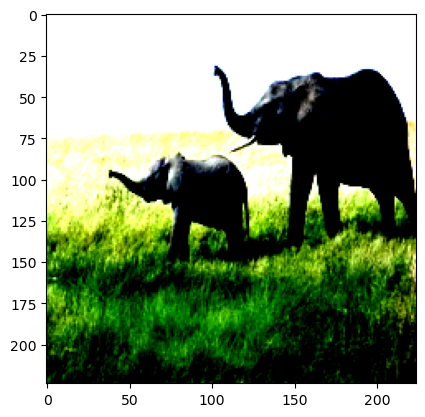

In [8]:
plt.imshow(img.squeeze().permute(1, 2, 0))

In [9]:
pred

tensor([386])

Now, we are going to do the back-propagation with the logit of the 386th class which represents the ‘African_elephant’ in the ImageNet dataset.

In [10]:
pred = vgg(img)

In [11]:
pred.shape

torch.Size([1, 1000])

In [12]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 386].backward()

In [13]:
# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

In [14]:
gradients.shape

torch.Size([1, 512, 14, 14])

In [15]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

In [16]:
pooled_gradients.shape

torch.Size([512])

In [17]:
np.argmax(pooled_gradients)

tensor(136)

In [18]:
np.argmin(pooled_gradients)

tensor(8)

In [19]:
# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

In [20]:
activations.shape

torch.Size([1, 512, 14, 14])

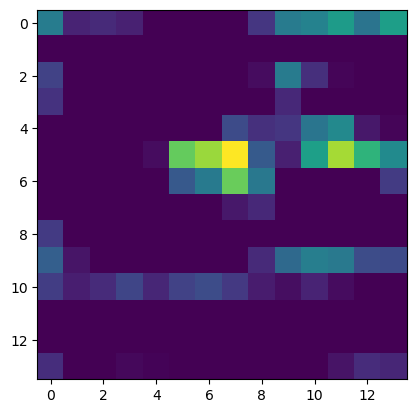

In [21]:
plt.imshow(activations.squeeze()[156, :, :])

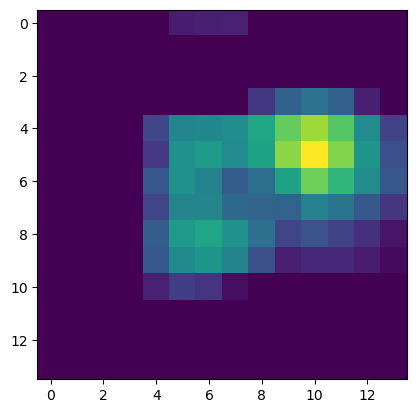

In [22]:
plt.imshow(activations.squeeze()[8, :, :])

In [23]:
# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

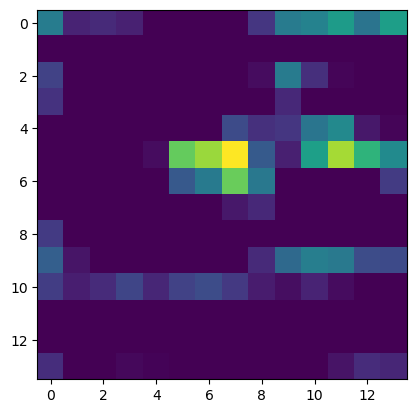

In [24]:
plt.imshow(activations.squeeze()[156, :, :])

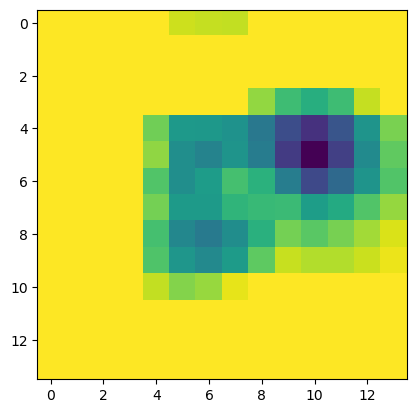

In [25]:
plt.imshow(activations.squeeze()[8, :, :])

In [26]:
activations.shape

torch.Size([1, 512, 14, 14])

In [27]:
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

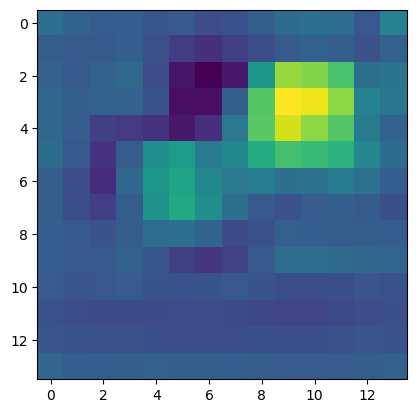

In [28]:
plt.imshow(heatmap)

In [29]:
print(heatmap.min(), heatmap.max())

tensor(-0.0001) tensor(0.0006)


In [30]:
# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

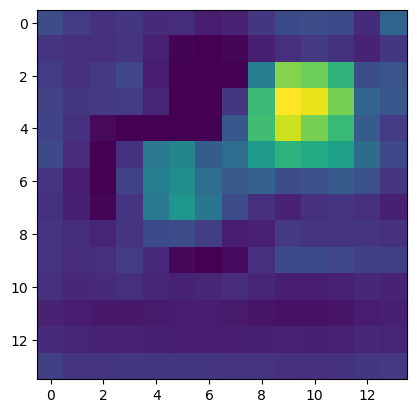

In [31]:
plt.imshow(heatmap)

In [32]:
# normalize the heatmap
heatmap /= torch.max(heatmap)

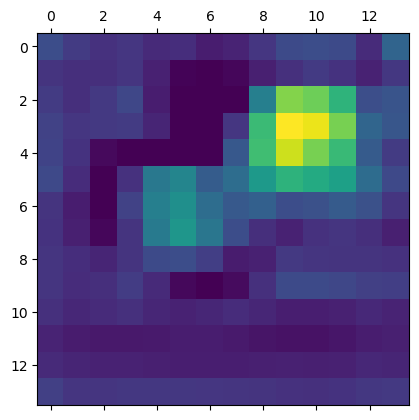

In [33]:
# draw the heatmap
plt.matshow(heatmap.squeeze())

Finally, we obtain the heat-map for the elephant image. It is a 14x14 single channel image. **The size is dictated by the spacial dimensions of the activation maps in the last convolutional layer of the network.**

In [34]:
import cv2

In [35]:
img = cv2.imread("./data/elephant/image_0001.webp")

In [36]:
img.shape

(280, 419, 3)

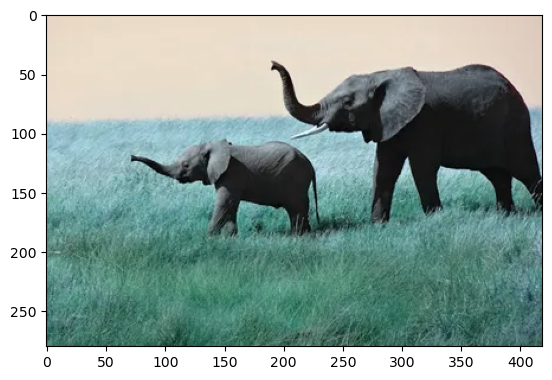

In [37]:
plt.imshow(img)

In [38]:
heatmap = cv2.resize(np.array(heatmap), (img.shape[1], img.shape[0]))

In [39]:
heatmap.shape

(280, 419)

In [40]:
heatmap.max()

0.99785423

In [41]:
heatmap = np.uint8(255 * heatmap)

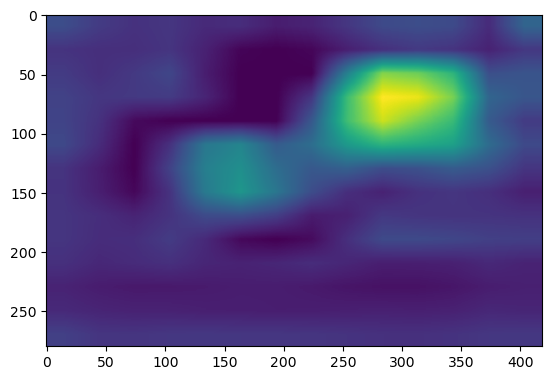

In [42]:
plt.imshow(heatmap)

In [43]:
# I used COLORMAP_RAINBOW instead of original COLORMAP_JET
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [44]:
superimposed_img = heatmap * 0.4 + img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


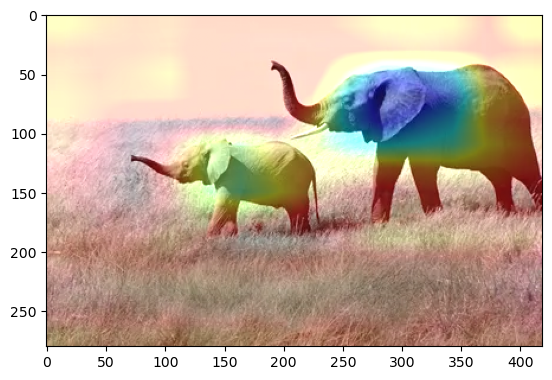

In [45]:
plt.imshow(superimposed_img / 255)

# Densenet201

In [46]:
from torchvision.models import densenet201

In [47]:
densenet201(pretrained=True)

C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\johnw/.cache\torch\hub\checkpoints\densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [48]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()

        # get the pretrained DenseNet201 network
        self.densenet = densenet201(pretrained=True)

        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features

        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)

        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1920))
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features_conv(x)

# ResNet152

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # define the resnet152
        self.resnet = resnet152(pretrained=True)
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier = self.resnet.fc
        
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        
        return x

      
# all the data transformation and loading
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = ImageFolder(root='./img/', transform=transform)
dataloader = data.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

# init the resnet
resnet = ResNet()

# set the evaluation mode
_ = resnet.eval()

# get the image
img, _ = next(iter(dataloader))

# forward pass
pred = resnet(img)

pred.argmax(dim=1) . # prints tensor([2])

# get the gradient of the output with respect to the parameters of the model
pred[:, 2].backward()

# pull the gradients out of the model
gradients = resnet.get_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = resnet.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

# make the heatmap to be a numpy array
heatmap = heatmap.numpy()

# interpolate the heatmap
img = cv2.imread('./img/data/1_506ySAThs6pItevFqZF-4g.jpeg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)